In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

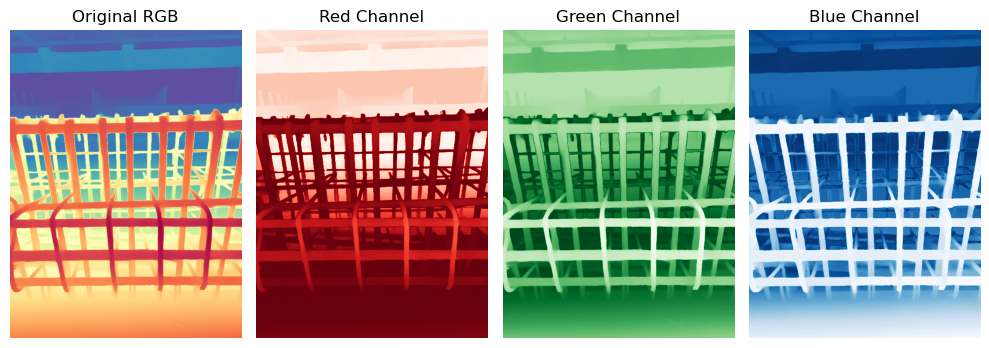

In [2]:
depth_map = cv.imread('depth_map_comparison/0.5m_pred/depth_anything_vitl/20250502_132954.png', cv.IMREAD_COLOR)
depth_map = cv.cvtColor(depth_map, cv.COLOR_BGR2RGB)  # Convert BGR to RGB
depth_map = cv.normalize(depth_map, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)

red_channel = depth_map[:,:,0]
green_channel = depth_map[:,:,1] 
blue_channel = depth_map[:,:,2]

plt.figure(figsize=(10, 5))

plt.subplot(1, 4, 1)
plt.imshow(depth_map)
plt.title('Original RGB')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(red_channel, cmap='Reds')
plt.title('Red Channel')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(green_channel, cmap='Greens')
plt.title('Green Channel')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(blue_channel, cmap='Blues')
plt.title('Blue Channel')
plt.axis('off')

plt.tight_layout()
plt.show()

### Find Corners

In [3]:
def find_corners(corner_image, display_image, maxCorners=100, qualityLevel=0.01, minDistance=10, blockSize=50, circle_radius=20, circle_color=(255, 0, 0)):
    # Detect corners in the corner detection image
    corners = cv.goodFeaturesToTrack(
        corner_image, 
        maxCorners=maxCorners, 
        qualityLevel=qualityLevel, 
        minDistance=minDistance, 
        blockSize=blockSize
    )
    
    # Create a copy of display image to draw corners on
    result_image = display_image.copy()
    
    if corners is not None:
        corners = np.intp(corners)
        
        # Draw circles around detected corners
        for corner in corners:
            x, y = corner.ravel()
            cv.circle(result_image, (x, y), circle_radius, circle_color, -1)
        
        return result_image
    else:
        return result_image

It seems that blue has the better representation of segmenting the closer bars.  

Next steps: 
- Try to get the shape of the bar by setting a thresholds

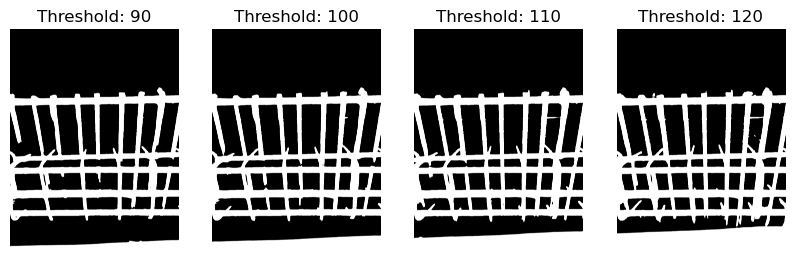

In [4]:
plt.figure(figsize=(10, 5))
thresholds = [90, 100, 110, 120]
for i in range(len(thresholds)):
    _, bar = cv.threshold(blue_channel, thresholds[i], 255, cv.THRESH_BINARY_INV)
    
    plt.subplot(1, len(thresholds), i + 1)
    plt.imshow(bar, cmap='gray')
    plt.title(f'Threshold: {thresholds[i]}')
    plt.axis('off')

I think by setting `threshold=110` captures the better representation of the bar, it shows the two layers of bar but without too many miscellaneous details.  

Next steps:
- Background Removal
- Try to segment the first and second layer.
- Set the two layers into different images

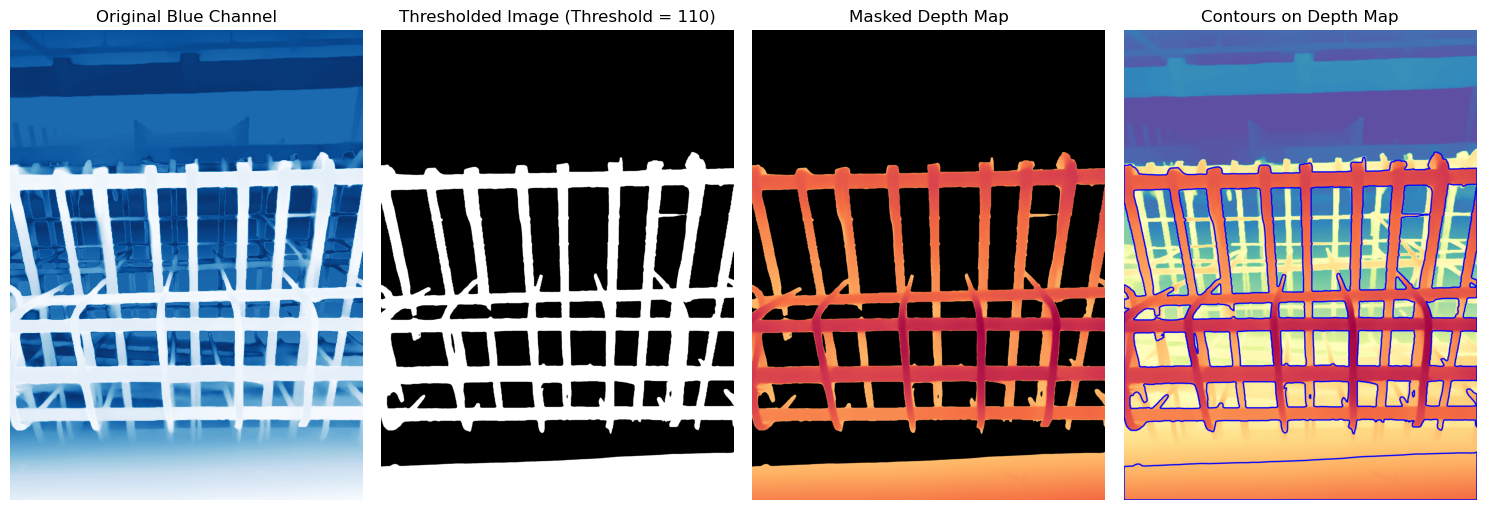

In [5]:
_, thresh = cv.threshold(blue_channel, 110, 255, cv.THRESH_BINARY_INV)
contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

depth_map_masked = cv.bitwise_and(depth_map, depth_map, mask=thresh)

depth_map_with_contours = depth_map.copy()
cv.drawContours(depth_map_with_contours, contours, -1, (0, 0, 255), 10, cv.LINE_AA)

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(blue_channel, cmap='Blues')
plt.title('Original Blue Channel')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(thresh, cmap='gray')
plt.title('Thresholded Image (Threshold = 110)')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(depth_map_masked)
plt.title('Masked Depth Map')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(depth_map_with_contours)
plt.title('Contours on Depth Map')
plt.axis('off')

plt.tight_layout()
plt.show()

🔵 First Layer  🟢 Second Layer


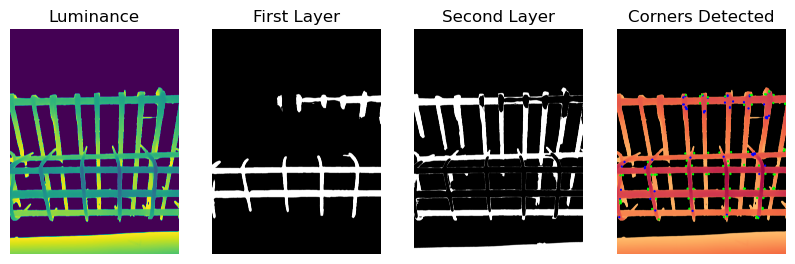

In [7]:
luminance = 0.299 * depth_map_masked[:,:,0] + 0.587 * depth_map_masked[:,:,1] + 0.114 * depth_map_masked[:,:,2]

first_layer_range = (luminance >= 25) & (luminance < 125)
first_layer = first_layer_range.astype(np.uint8) * 255
second_layer_range = (luminance >= 125) & (luminance < 175)
second_layer = second_layer_range.astype(np.uint8) * 255

display_image = find_corners(first_layer, depth_map_masked, circle_color=(0, 0, 255))
display_image = find_corners(second_layer, display_image, circle_color=(0, 255, 0))

plt.figure(figsize=(10, 5))
print('🔵 First Layer  🟢 Second Layer')

plt.subplot(1, 4, 1)
plt.imshow(luminance)
plt.title('Luminance')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(first_layer, cmap='gray')
plt.title('First Layer')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(second_layer, cmap='gray')
plt.title('Second Layer')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(display_image)
plt.title('Corners Detected')
plt.axis('off')

plt.show()

As you can see, the second layer is ugly due to the edges of the bar,  
the result is the corner detection of the second layer is on the first layer.

Next Steps:
- try to smooth out the edges using blur (https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html)
- try to use k-means as threshold (https://docs.opencv.org/4.x/d1/d5c/tutorial_py_kmeans_opencv.html)

In [8]:
def apply_blurring(image, kernel_size: tuple):
    kernel = np.ones(kernel_size, np.float32) / (kernel_size[0] * kernel_size[1])
    blurred_image = cv.filter2D(image, -1, kernel)
    return blurred_image

### Blurring
- Method 1: segement the layers first, then apply blurring.  
- Method 2: apply blurring first, then segment the layers.

🔵 First Layer  🟢 Second Layer


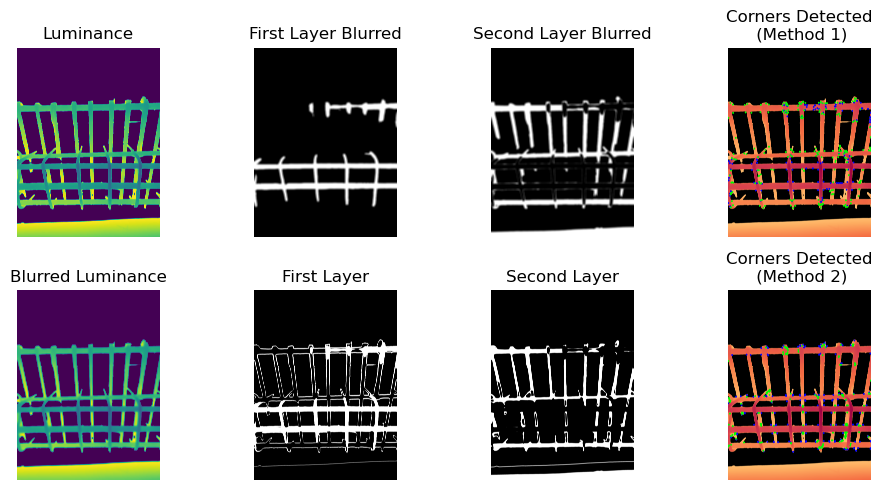

In [9]:
# Method 1
first_layer_range = (luminance >= 25) & (luminance < 125)
first_layer = first_layer_range.astype(np.uint8) * 255
second_layer_range = (luminance >= 125) & (luminance < 175)
second_layer = second_layer_range.astype(np.uint8) * 255

first_layer_blurred = apply_blurring(first_layer, (50, 50))
second_layer_blurred = apply_blurring(second_layer, (50, 50))

method1 = find_corners(first_layer_blurred, depth_map_masked, maxCorners=200, circle_color=(0, 0, 255))
method1 = find_corners(second_layer_blurred, method1, maxCorners=200, circle_color=(0, 255, 0))

plt.figure(figsize=(10, 5))
print('🔵 First Layer  🟢 Second Layer')

# Display Method 1
plt.subplot(2, 4, 1)
plt.imshow(luminance)
plt.title('Luminance')
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(first_layer_blurred, cmap='gray')
plt.title('First Layer Blurred')
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(second_layer_blurred, cmap='gray')
plt.title('Second Layer Blurred')
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(method1)
plt.title('Corners Detected\n (Method 1)')
plt.axis('off') 

# Method 2
depth_map_blurred = apply_blurring(luminance, (50, 50))
depth_map_blurred = cv.bitwise_and(depth_map_blurred, depth_map_blurred, mask=thresh) # Trim the excess

first_layer_range = (depth_map_blurred >= 25) & (depth_map_blurred < 125)
first_layer = first_layer_range.astype(np.uint8) * 255
second_layer_range = (depth_map_blurred >= 125) & (depth_map_blurred < 175)
second_layer = second_layer_range.astype(np.uint8) * 255

method2 = find_corners(first_layer, depth_map_masked, maxCorners=200, circle_color=(0, 0, 255))
method2 = find_corners(second_layer, method2, maxCorners=200, circle_color=(0, 255, 0))

plt.subplot(2, 4, 5)
plt.imshow(depth_map_blurred)
plt.title('Blurred Luminance')
plt.axis('off')

plt.subplot(2, 4, 6)
plt.imshow(first_layer, cmap='gray')
plt.title('First Layer')
plt.axis('off')

plt.subplot(2, 4, 7)
plt.imshow(second_layer, cmap='gray')
plt.title('Second Layer')
plt.axis('off')

plt.subplot(2, 4, 8)
plt.imshow(method2)
plt.title('Corners Detected\n (Method 2)')
plt.axis('off')

plt.tight_layout()
plt.show()

It seems that Method 2 perform better on detecting corners of second layer,  
but it depends on the intersection of the first layer.

### Color Quantization

In [10]:
def kmeans_quantization(image, k, max_iter=20, epsilon=1.0):
    data = image.reshape(-1, 3)
    data = np.float32(data)
    
    criteria = (cv.TermCriteria_EPS + cv.TermCriteria_MAX_ITER, max_iter, epsilon)
    _, labels, centers = cv.kmeans(data, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
    
    centers = np.uint8(centers)
    quantized_image = centers[labels.flatten()]
    quantized_image = quantized_image.reshape(image.shape)
    
    return quantized_image, labels, centers

In [11]:
kmeans = [2, 3, 4, 5]
quantizations = []
for k in kmeans:
    quantized_image, labels, centers = kmeans_quantization(depth_map_masked, k)
    quantizations.append({
        'quantized_image': quantized_image,
        'labels': labels,
        'centers': centers,
    })

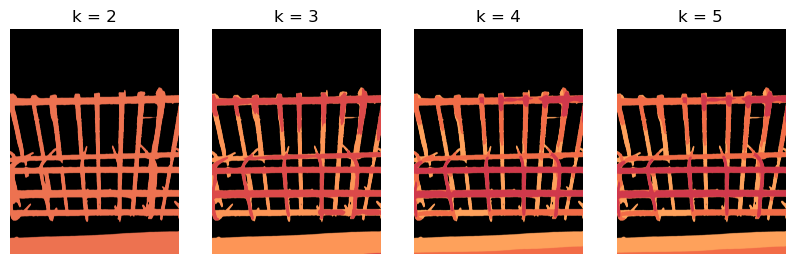

In [12]:
plt.figure(figsize=(10, 4))

for i, quantization in enumerate(quantizations):
    quantized_image = quantization['quantized_image']   
    plt.subplot(1, 4, i + 1)
    plt.imshow(quantized_image)
    plt.title(f'k = {i + 2}')
    plt.axis('off')

plt.show()

It seems that k = 4 has the better representation of the bars

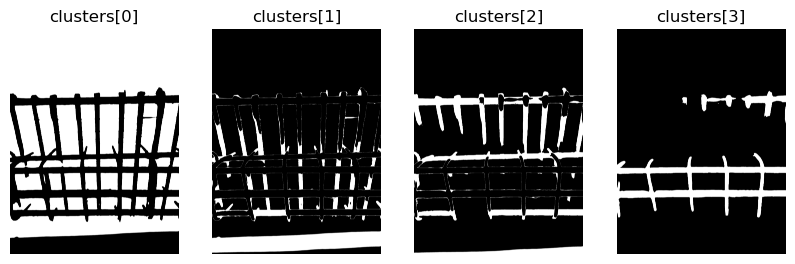

In [13]:
plt.figure(figsize=(10, 4))
# find centers in k = 4
quantized_image = quantizations[2]['quantized_image']
centers = quantizations[2]['centers']
clusters = []
for i, center in enumerate(centers):
    cluster = (quantized_image == center).astype(np.uint8) * 255
    clusters.append(cluster)
    
    plt.subplot(1, 4, i + 1)
    plt.imshow(cluster)
    plt.title(f'clusters[{i}]')
    plt.axis('off')
    
plt.show()
    

🔵 First Layer  🟢 Second Layer


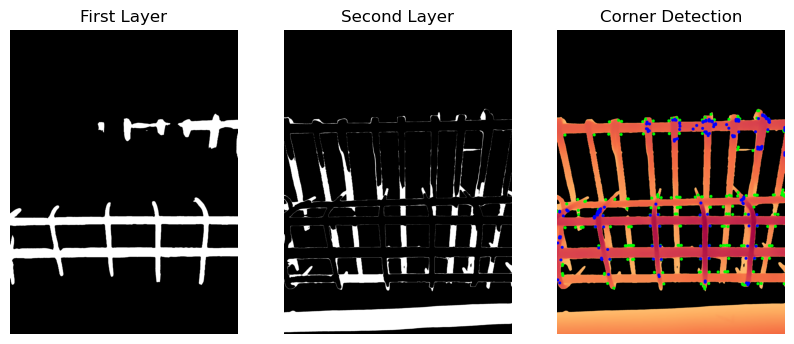

In [14]:
# Convert clusters to proper grayscale for corner detection
cluster1_gray = clusters[1][:,:,0] 
cluster3_gray = clusters[3][:,:,0] 

# Apply corner detection to both clusters
display_image = find_corners(cluster1_gray, depth_map_masked, maxCorners=200, circle_color=(0, 255, 0))  # Blue for cluster 1
display_image = find_corners(cluster3_gray, display_image, maxCorners=200, circle_color=(0, 0, 255))     # Green for cluster 3

plt.figure(figsize=(10, 5))
print('🔵 First Layer  🟢 Second Layer')

plt.subplot(1, 3, 1)
plt.imshow(cluster3_gray, cmap='gray')
plt.title('First Layer')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cluster1_gray, cmap='gray')
plt.title('Second Layer')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(display_image)
plt.title('Corner Detection')
plt.axis('off')

plt.show()

It appears to have similar result with blurring method 2

### Conclusion
We tried different methods to segments layers to detect corners, include **thresholding**, **blurring**, and **kmeans**. Despite having the dots land on different layers of bar, the process still heavily relies on tuning the parameter manually.  

Some of the blue dots that is suppose to land on the first layer land on the second layer, the photographer might have to take the photo perpendicular to the ground(taking it in the right angle), to avoid detection error.